## makemore: part 5 (building a WaveNet)

[DeepMind blog post from 2016](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


### Prvious MLP

In [7]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    ## outside backpropagation
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
# class FlattenConsecutive:

#   def __init__(self, n):
#     self.n = n

#   def __call__(self, x):
#     B, T, C = x.shape
#     x = x.view(B, T//self.n, C*self.n)
#     if x.shape[1] == 1:
#       x = x.squeeze(1)
#     self.out = x
#     return self.out

#   def parameters(self):
#     return []


In [8]:
torch.manual_seed(42); # seed rng for reproducibility

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd)) # character embeddings
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),
  Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


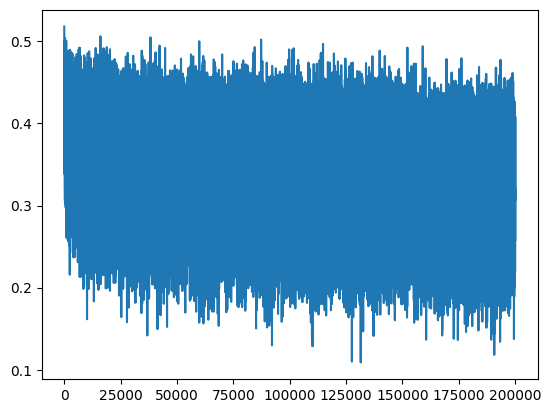

In [11]:
# size of mini batch is too small, so the training is unstable
plt.plot(lossi)

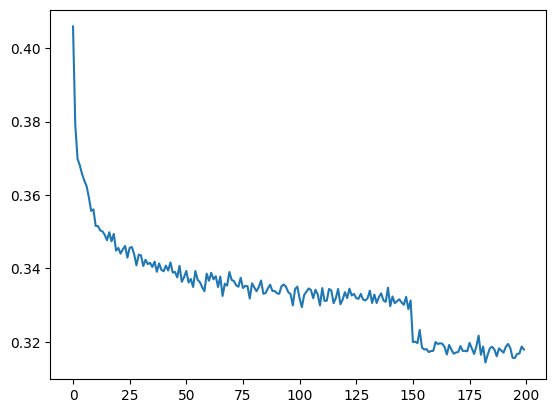

In [15]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [12]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
  layer.training = False


In [13]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N,block_size,n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N,block_size*n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065292358398438


In [14]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])]
      x = emb.view(emb.shape[0], -1)
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


### Wavenet

In [32]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
## expect input (N,C) or (N,L,C) while torch.batchnorm1d expect (N,C,L)
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    # # prev version
    # if self.training:
    #   xmean = x.mean(0, keepdim=True) # batch mean
    #   xvar = x.var(0, keepdim=True) # batch variance
    # else:
    #   xmean = self.running_mean
    #   xvar = self.running_var
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    ##indexing operation in the forward pass
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
# class Flatten:

  # def __call__(self, x):
    # self.out = x.view(x.shape[0], -1)
    # return self.out

  # def parameters(self):
    # return []

# -----------------------------------------------------------------------------------------------
## split each embeddings into groups of sub-embeddings
class FlattenConsecutive:

  ## how many consecutive elements/groups of sub-embds
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape # T:batch size, T:context size, C:embd size
    ## prev: x = x.view(B,-1)
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1) ## if T//self.n is 1, then remove this dimension
    self.out = x
    return self.out

  def parameters(self):
    return []

# # -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self,
               layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [33]:
torch.manual_seed(42); # seed rng for reproducibility

In [34]:
## network after add embedding layer and flatten layer
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons in the hidden layer of the MLP
# layers = [
#     Embedding(vocab_size, n_embd),
#     Flatten(),
#     Linear(n_embd * block_size, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, vocab_size),
# ]


# # ## original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 200 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#     Embedding(vocab_size, n_embd),
#     # Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     # Linear(n_hidden, vocab_size),
#     FlattenConsecutive(block_size),
#     Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 #10 # the dimensionality of the character embedding vectors
n_hidden = 128 #200 #68 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  # layers[-1].weight *= 0.1
  model.layers[-1].weight *= 0.1 # last layer make less confident

# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


### Improve flatten layer for parallel computation, split embeddings into groups

In [15]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # look at a batch of just 4 example
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  7,  1, 18, 18],
        [ 0,  0,  2,  1, 18,  3, 12,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 20]])

In [16]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [29]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True) #1,4,68
emean2 = e.mean((0,1), keepdim=True) #1,1,68
evar = e.var(0, keepdim=True) #1,4,68
evar2 = e.var((0,1), keepdim=True) #1,1,68
ehat = (e-emean)/torch.sqrt(evar+1e-5) #32,4,68
ehat.shape

torch.Size([32, 4, 68])

In [28]:
## first batchnorm layer
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [26]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [27]:
model.layers[1].out.shape

torch.Size([4, 80])

In [28]:
model.layers[2].out.shape

torch.Size([4, 200])

In [36]:
(torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape

torch.Size([4, 200])

In [38]:
## multiplication only works on the last dimension
## all dimensions on the left are all treated as batch dimension
(torch.randn(4,5,80) @ torch.randn(80,200)).shape

torch.Size([4, 5, 200])

In [ ]:
# 1 2 3 4 5 6 7 8 -> (1 2) (3 4) (5 6) (7 8) process in parallel

In [ ]:
# (torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape
# emb_dim = 8, split it into 4*2, then (4,80)@(80,200) -> (4,4,20)@(20,200), 20=len_of_consecutive_emb*hidden_dim
(torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape

In [41]:
print(list(range(10)[1::2])) #even
print(list(range(10)[::2])) #odd

[1, 3, 5, 7, 9]
[0, 2, 4, 6, 8]


In [46]:
e = torch.randn(4, 8, 10) # want this to be (4,4,20) where consecutive 10-d vectors get concatenated
e.view(4,-1).shape

torch.Size([4, 80])

In [47]:
explicit = torch.cat([e[:,::2,:],e[:,1::2,:]],dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [48]:
(e.view(4,4,20)==explicit).all()

tensor(True)

### continue training

In [35]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  # x = Xb
  # for layer in layers:
    # x = layer(x)
  logits = model(Xb)
  # loss = F.cross_entropy(x, Yb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8805
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


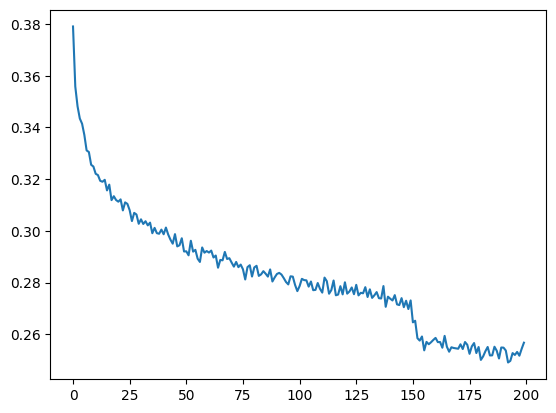

In [36]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [37]:
# put layers into eval mode (needed for batchnorm especially)
# for layer in layers:
for layer in model.layers:
  layer.training = False

In [38]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  # emb = C[x]
  # x = emb.view(emb.shape[0], -1)
  # for layer in model.layers:
  #   x = layer(x)
  # loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690281867980957
val 1.9936515092849731


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm (only consider 2 dimension like (4,80), now modify to multiple dimensions like (4,4,20)): train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [39]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

aiyanah.
giusopf.
lorron.
roger.
rhyitte.
christell.
jedmccee.
kelipson.
briyah.
sylot.
zennica.
mythan.
daxphon.
petrit.
adalie.
jeniyah.
glatipe.
manaswi.
yeslee.
stephania.


### Next time:
Why convolutions? Brief preview/hint

In [40]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [44]:
# forward a single example:
logits = model(Xtr[[7]])
##logits value for 27 possible cases of characters
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space